# 01_Data_Loading

## Introduction

In this notebook, we'll load EEG data from EDF files, perform initial inspections, and visualize the raw signals to understand their structure and quality.

## Step 1: Import Libraries

We'll start by importing the necessary Python libraries required for data loading, processing, and visualization.

In [9]:
# Import essential libraries
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from mne.viz import plot_topomap

# Configure visualization settings
# Allow the plots to be displayed in the notebook immediately after the code
%matplotlib inline
# Set the Seaborn theme to "darkgrid" for all plots
sns.set_theme(style="darkgrid")

## Step 2: Load EDF Files

Next, we'll load the EEG data from EDF (European Data Format) files using MNE-Python. We'll inspect the data structure and ensure it's loaded correctly.

In [2]:
# Define the path to the EDF file
edf_file = '../data/raw data/S001/S001R04.edf'

# Load the raw EEG data
raw = mne.io.read_raw_edf(edf_file, preload=True)

# Display basic information about the loaded data
print(raw.info)

Extracting EDF parameters from /Users/helechuan/Library/Mobile Documents/com~apple~CloudDocs/Documents/4th Year University/4th Year Project/64-Channels-EEG-Data-ML-training/data/raw data/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>


## Step 3: Visualize Raw EEG Data

Visualizing the raw EEG signals provides insights into the data structure and helps identify any obvious artifacts or anomalies. We'll plot a segment of the EEG data for a subset of channels.

Using matplotlib as 2D backend.


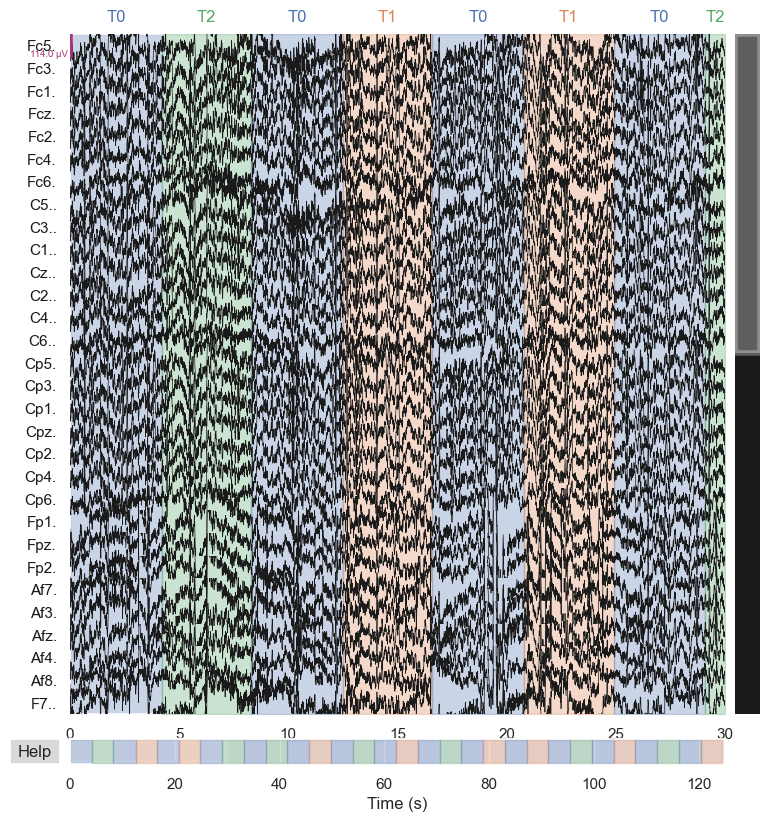

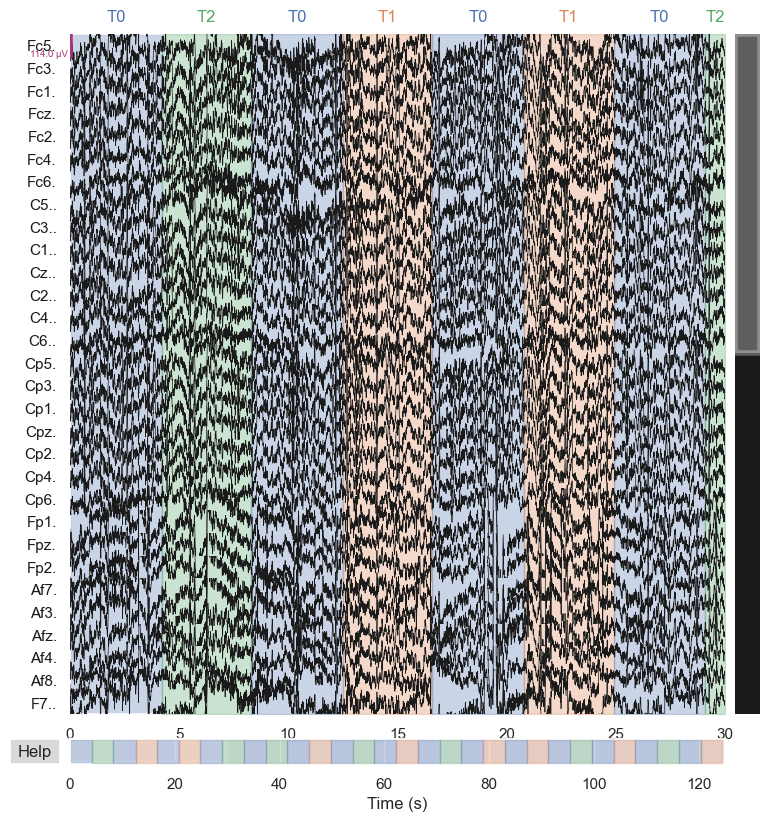

In [3]:

# Plot raw EEG data interactively

# The plot would display the EEG signals for the first 30 channels, and for the first 30 seconds.
raw.plot(duration=30, n_channels=30, scalings='auto', title='Raw EEG Signals', show=True)

## Step 4: Open the .edf.event document
To find out what the T0, T1, and T2 are, we need to open the edf.event document to check.

In [4]:
# Define the path to the EDF file
edf_event = '../data/raw data/S001/S001R04.edf'

# Load the raw EEG data with annotations
raw = mne.io.read_raw_edf(edf_event, preload=True)

# Access annotations
annotations = raw.annotations

# Display annotations
print(annotations)

Extracting EDF parameters from /Users/helechuan/Library/Mobile Documents/com~apple~CloudDocs/Documents/4th Year University/4th Year Project/64-Channels-EEG-Data-ML-training/data/raw data/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<Annotations | 30 segments: T0 (15), T1 (8), T2 (7)>


Although we didn't find out what these are through the annotations, we did eventually found that: T0 is resting, T1 is left fist, and T2 is right fist.

## Step 5 Labelling the Epochs
I can utilize the labels attached to each segment (epoch) of my EEG data to train my ML model effectively. The key is to segment (epoch) the continuous EEG data based on the event markers and ensure that each epoch is correctly labeled. The ML algorithm can then learn from these labeled epochs without the need for physically separating the data into different files.

The focus should be on automatically segmenting and labeling the data within the processing pipeline. 

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
{'Rest': 1, 'Imagining Left Hand': 2, 'Imagining Right Hand': 3}
Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
1 bad epochs dropped
<Epochs | 29 events (all good), -0.2 – 3.8 s (baseline -0.2 – 0 s), ~9.1 MB, data loaded,
 'Rest': 14
 'Imagining Left Hand': 8
 'Imagining Right Hand': 7>


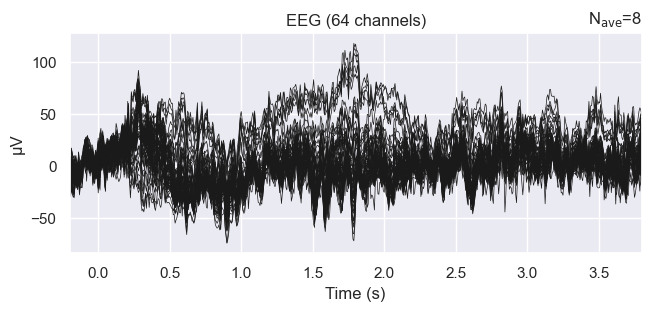

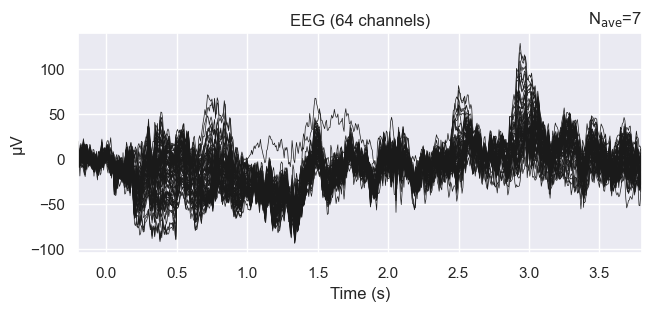

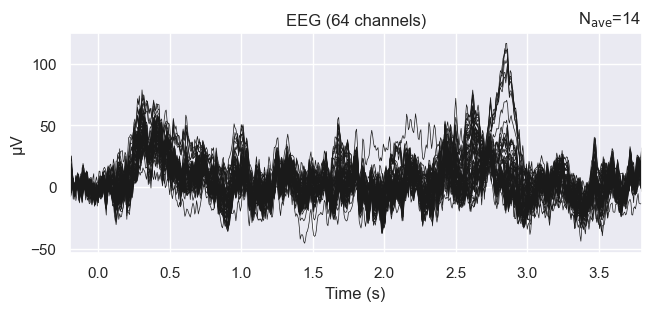

In [5]:
# Define event dictionary
event_dict = {
    'Rest': 1,                # T0
    'Imagining Left Hand': 2,  # T1
    'Imagining Right Hand': 3  # T2
}

# Convert annotations to events and event_id
events, event_id = mne.events_from_annotations(raw)

# Update event_id with descriptive labels
event_id = {
    'Rest': 1,
    'Imagining Left Hand': 2,
    'Imagining Right Hand': 3
}

print(event_id)

from mne import Epochs

# Define epoch parameters
tmin = -0.2  # 200 ms before the event
tmax = 3.8   # 3800 ms after the event
baseline = (None, 0)  # Baseline correction

# Create epochs
epochs = Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=baseline, preload=True)

# Display epoch information
print(epochs)


# Plot an average epoch for 'Imagining Left Hand'
fig = epochs['Imagining Left Hand'].average().plot()
fig.suptitle('Imagining Left Hand')
plt.show()

# Plot an average epoch for 'Imagining Right Hand'
fig = epochs['Imagining Right Hand'].average().plot()
fig.suptitle('Imagining Right Hand')
plt.show()

# Plot an average epoch for 'Rest'
fig = epochs['Rest'].average().plot()
fig.suptitle('Rest')
plt.show()


# Prepare the Data for Classification

In [6]:
#First, let’s filter out the epochs corresponding to 'Rest' and keep only the motor imagery epochs.

# Select only 'Imagining Left Hand' and 'Imagining Right Hand' epochs
motor_epochs = epochs[['Imagining Left Hand', 'Imagining Right Hand']]

# Extract labels: 0 for Left, 1 for Right
labels = motor_epochs.events[:, -1] - 2  # 'Imagining Left Hand' = 2, 'Imagining Right Hand' = 3

# Verify the distribution of classes
print("Class distribution:", np.bincount(labels))

Class distribution: [8 7]


## Conver the epochs into arrays

In [7]:
# Get the data as a NumPy array: shape (n_epochs, n_channels, n_times)
X = motor_epochs.get_data()
y = labels

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (15, 64, 641)
Shape of y: (15,)


Defining multiple frequency bands allows FBCSP to capture relevant patterns across different EEG frequencies. Commonly used bands for motor imagery include alpha and beta, but you can adjust these based on your specific requirements.

The Max Gamma filter is set to be less than the Nyquist Frequency of 80Hz

In [12]:
# Define frequency bands (in Hz)
freq_bands = [
    (8, 12),    # Alpha
    (13, 20),   # Beta 1
    (21, 30),   # Beta 2
    (31, 40),   # Low Gamma
    (41, 50),   # High Gamma
    (51, 60),   # Very High Gamma
    (61, 70),   # Ultra High Gamma
    (71, 79)    # Max Gamma
]

Create a function to perform FBCSP, which includes filtering, applying CSP, and extracting log-variance features.

In [13]:
def extract_fbcsp_features(X, y, sfreq, freq_bands, n_csp=4):
    """
    Extract FBCSP features from EEG data.
    
    Parameters:
    - X: EEG data, shape (n_trials, n_channels, n_times)
    - y: Labels, shape (n_trials,)
    - sfreq: Sampling frequency
    - freq_bands: List of tuples defining frequency bands
    - n_csp: Number of CSP components per band
    
    Returns:
    - X_features: Extracted features, shape (n_trials, n_bands * n_csp * 2)
    """
    from mne.filter import filter_data
    from sklearn.model_selection import StratifiedKFold
    
    # Initialize list to hold features from all bands
    X_features = []
    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize array to store CSPs for each band
    csp_list = []
    
    for band in freq_bands:
        print(f'Processing band: {band[0]}-{band[1]} Hz')
        
        # 1. Band-pass filter the data for the current frequency band
        X_filtered = np.array([
            filter_data(trial, sfreq=sfreq, l_freq=band[0], h_freq=band[1], method='iir', verbose=False)
            for trial in X
        ])
        
        # 2. Initialize CSP
        csp = CSP(n_components=n_csp, reg=None, log=True, norm_trace=False)
        
        # 3. Fit CSP on the entire dataset
        csp.fit(X_filtered, y)
        csp_list.append(csp)
        
        # 4. Transform the data using CSP
        X_csp = csp.transform(X_filtered)
        
        # 5. Take log-variance of the CSP features
        X_logvar = np.log(np.var(X_csp, axis=1))
        
        # 6. Append the features
        X_features.append(X_logvar)
    
    # Concatenate features from all bands
    X_features = np.array(X_features).T  # Shape: (n_trials, n_bands * n_csp)
    
    return X_features, csp_list

In [14]:
# Define sampling frequency
sfreq = raw.info['sfreq']  # 160 Hz

# Extract FBCSP features
X_features, csp_models = extract_fbcsp_features(X, y, sfreq, freq_bands, n_csp=4)

print(f"Shape of extracted features: {X_features.shape}")

Processing band: 8-12 Hz
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Processing band: 13-20 Hz
Computing rank from data with rank=None
    Using tolerance 9.1e-05 (2.2e-16 eps * 64 dim * 6.4e+09  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Processing band: 21-30 Hz
Computing rank from data with rank=None
    Using tolerance 6.1e-05 (2.2e-16 eps * 64 dim * 4.3e+09  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projec